In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import transformers
import torch
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

df = pd.read_csv('comments.tsv',
                 sep='\t')

In [ ]:
text = df['comment_text'].values
target = df['should_ban'].values
print(df.head())

   should_ban                                       comment_text
0           0  The picture on the article is not of the actor...
1           1  Its madness. Shes of Chinese heritage, but JAP...
2           1  Fuck You. Why don't you suck a turd out of my ...
3           1  God is dead\nI don't mean to startle anyone bu...
4           1  THIS USER IS A PLANT FROM BRUCE PERENS AND GRO...


In [ ]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
train_data, test_data, train_target, test_target = train_test_split(text, target, test_size=0.3)

In [ ]:
text_train_tokenized = [tokenizer.encode(x, max_length=512, add_special_tokens=True) for x in train_data]
text_test_tokenized = [tokenizer.encode(x, max_length=512, add_special_tokens=True) for x in test_data]

In [ ]:
# Padding

def pad_text(text_raw):
    MAX_LEN = 0
    for elem in text_raw:
        if len(elem) > MAX_LEN:
          MAX_LEN = len(elem)

    return np.array([elem + [0] * (MAX_LEN - len(elem)) for elem in text_raw])

train_padded = pad_text(text_train_tokenized)
test_padded = pad_text(text_test_tokenized)

In [ ]:
attention_mask_train = torch.tensor(np.where(train_padded != 0, 1, 0))
attention_mask_test = torch.tensor(np.where(test_padded != 0, 1, 0))


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.eval()
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSelfAttention(
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
device

In [ ]:
print(test_padded.shape)
train_padded.shape

(300, 512)


(700, 512)

In [ ]:
import tqdm
output = []
batch_size = 16

for i in tqdm.tnrange(0, 700, batch_size):
    batch = torch.tensor(train_padded[i:i + batch_size]).to(device)
    local_attention_mask = torch.tensor(attention_mask_train[i:i + batch_size]).to(device)

    with torch.no_grad():
        last_hidden_states = model(batch, attention_mask=local_attention_mask)[0][:, 0, :].cpu().numpy()
        output.append(last_hidden_states)

In [ ]:
output_test = []
batch_size = 16

for i in tqdm.tnrange(0, 300, batch_size):
    batch = torch.tensor(test_padded[i:i + batch_size]).to(device)
    local_attention_mask = torch.tensor(attention_mask_test[i:i + batch_size]).to(device)

    with torch.no_grad():
        last_hidden_states = model(batch, attention_mask=local_attention_mask)[0][:, 0, :].cpu().numpy()
        output_test.append(last_hidden_states)

In [ ]:
output, output_test = output[:44], output[44:]
print(len(output), len(output_test))

In [ ]:
train_features = np.vstack(output)
test_features = np.vstack(output_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_target)

In [ ]:
lr_clf.score(test_features, test_target)

0.8766666666666667

0.9931709946985353 train
0.9454197964353971 test


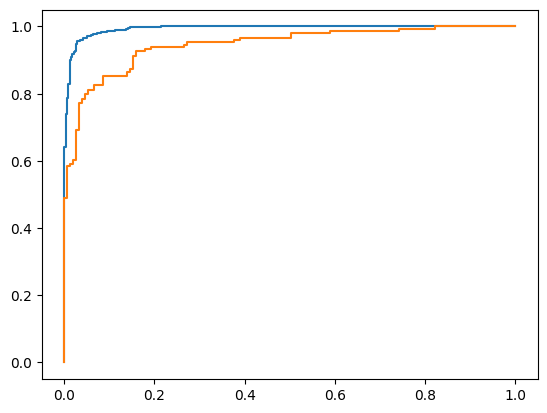

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

proba = lr_clf.predict_proba(train_features)[:, 1]
auc = roc_auc_score(train_target, proba)
print(auc, 'train')
plt.plot(*roc_curve(train_target, proba)[:2])

proba = lr_clf.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_target, proba)
print(auc, 'test')
plt.plot(*roc_curve(test_target, proba)[:2])
plt.show()